In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage import io, transform

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
import time
import copy

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

### Dataset creation

In [2]:
subset = 'train'
resized = 'resized2'

folder = ".."+os.sep+"data"+os.sep
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep

#Create mapping for labels
df = pd.read_csv(folder + file)
classes = df.classid.unique()
classes.sort()
classes_map = { classes[i]:i for i in range(len(classes)) }

In [3]:
# Plot image for testing
def show_image(image, label):
    plt.imshow(image)
    plt.title(label)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
#Défénition d"une class de pytorch

# Dataset Class
class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform #Pytorch ne traite pas les même vecteurs d'images, nous y appliquons une transformation
        self.classes_map = classes #Les classes des plante (attention il faut convertir le numéro des classe entre 1 et 50 pour les rendre continue)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 1]))
        image = io.imread(img_name + '.jpg')
        label = self.df.iloc[idx, 4]
        sample = {'image': image, 'label': classes_map[label]}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

### Neural Network initialisation


In [5]:
resized = 'resized2'
folder = ".."+os.sep+"data"+os.sep

#Transformation dans un Tensor (comme une liste) et les valeur de chaque pixel (de 0 à 255) sont converti de 0 à 1
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#note : pour ne pas faire la decente de gradient par apport à la moyenne des tesst sur toute les image, nous entrainons sur des mini batch de 4 images

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Validation Data
subset = 'validation'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
valset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=False, num_workers=0)

#Test Data
subset = 'test'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

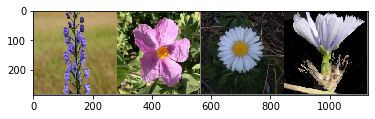

   39    12     2     6


In [6]:
# Show 4 random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
batch = dataiter.next()
images, labels = batch['image'], batch['label']

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].data.numpy() for j in range(4)))

In [7]:
#le coeur du procéssus, l'architecture.
# Neural Network Architecture
# class Net(nn.Module):
#     #Dans un premier temps nous initialisons les différente couche
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 8, 5) #Appliquer un filtre à une image de 3 dimention pour la transformer en 8 dimention avec un filtre de taille 5*5
#         self.pool = nn.MaxPool2d(2, 2)  #Prend des carré de pixel de taille 2*2 et les réduit à un seul pixel (diminue de deux la taille d'une image)
#         self.conv2 = nn.Conv2d(8, 25, 5) #Appliquer un filtre à une image de 8 dimention pour la transformer en 25 dimention avec un filtre de taille 5*5
#         self.fc1 = nn.Linear(25 * 67 * 67, 640) #Input (nombre de neuronne 25*64*64) et 1 colonne de neuronne (nombre de neuronne 640)
#         self.fc2 = nn.Linear(640, 256)
#         self.fc3 = nn.Linear(256, 50) #à la dernière couche il faut obligatoirement 50 neuronne, 1 par classe

#     #ordre de traitement des couche
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 25 * 67 * 67)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class Net(nn.Module):
    #Dans un premier temps nous initialisons les différente couche
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) 
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(32 * 67 * 67, 1024) 
        self.fc2 = nn.Linear(1024, 50) 

    #ordre de traitement des couche
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 32 * 67 * 67)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {"train" : list(), "val": list()}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data['image'].to(device), data['label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            history[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloaders['val']):
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format(preds[j],labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
def plot_history(history):
    plt.plot(history['train'])
    plt.plot(history['val'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    ticks = list(range(len(history['train'])))
    names = list(range(1,len(history['train'])+1))
    plt.xticks(ticks, names)
    plt.show()

In [11]:
def get_preds(net, loader):
    preds = list()
    with torch.no_grad():
        for data in testloader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().detach().numpy())
    return preds

In [12]:
def get_accuracy(net, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 695 test images: %d %%' % (100 * correct / total))

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(32, 24))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.savefig('cm.png')
    plt.show()

In [14]:
def plot_history(history):
    plt.plot(history['train'])
    plt.plot(history['val'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    ticks = list(range(len(history['train'])))
    names = list(range(1,len(history['train'])+1))
    plt.xticks(ticks, names)
    plt.show()

In [15]:
# Optmization
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
# Use the GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=143648, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=50, bias=True)
)

In [17]:
net, history = train_model(net, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.9013 Acc: 0.0336
val Loss: 3.8615 Acc: 0.0446

Epoch 1/24
----------
train Loss: 3.6794 Acc: 0.0566
val Loss: 3.4254 Acc: 0.0978

Epoch 2/24
----------
train Loss: 3.2190 Acc: 0.1416
val Loss: 2.9929 Acc: 0.2086

Epoch 3/24
----------
train Loss: 2.7423 Acc: 0.2514
val Loss: 2.6455 Acc: 0.2734

Epoch 4/24
----------
train Loss: 2.3195 Acc: 0.3560
val Loss: 2.8020 Acc: 0.2532

Epoch 5/24
----------
train Loss: 1.9359 Acc: 0.4573
val Loss: 2.9051 Acc: 0.2791

Epoch 6/24
----------
train Loss: 1.5446 Acc: 0.5797
val Loss: 3.0758 Acc: 0.2518

Epoch 7/24
----------
train Loss: 0.4596 Acc: 0.8796
val Loss: 2.9619 Acc: 0.3281

Epoch 8/24
----------
train Loss: 0.1905 Acc: 0.9525
val Loss: 3.3724 Acc: 0.3468

Epoch 9/24
----------
train Loss: 0.0910 Acc: 0.9798
val Loss: 3.7057 Acc: 0.3309

Epoch 10/24
----------
train Loss: 0.0492 Acc: 0.9928
val Loss: 3.9975 Acc: 0.3439

Epoch 11/24
----------
train Loss: 0.0219 Acc: 0.9990
val Loss: 4.2693 Acc: 0.3424

Ep

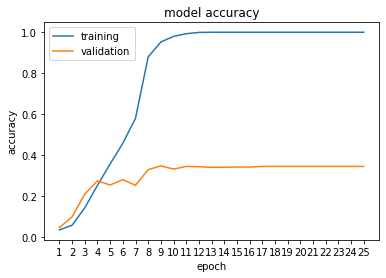

In [18]:
plot_history(history)

In [19]:
y_predict = get_preds(net, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)

In [20]:
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.3510791366906475
Rappel: 0.3510791366906475
Precision: 0.356824011104315
F-Measure: 0.34372889716854305


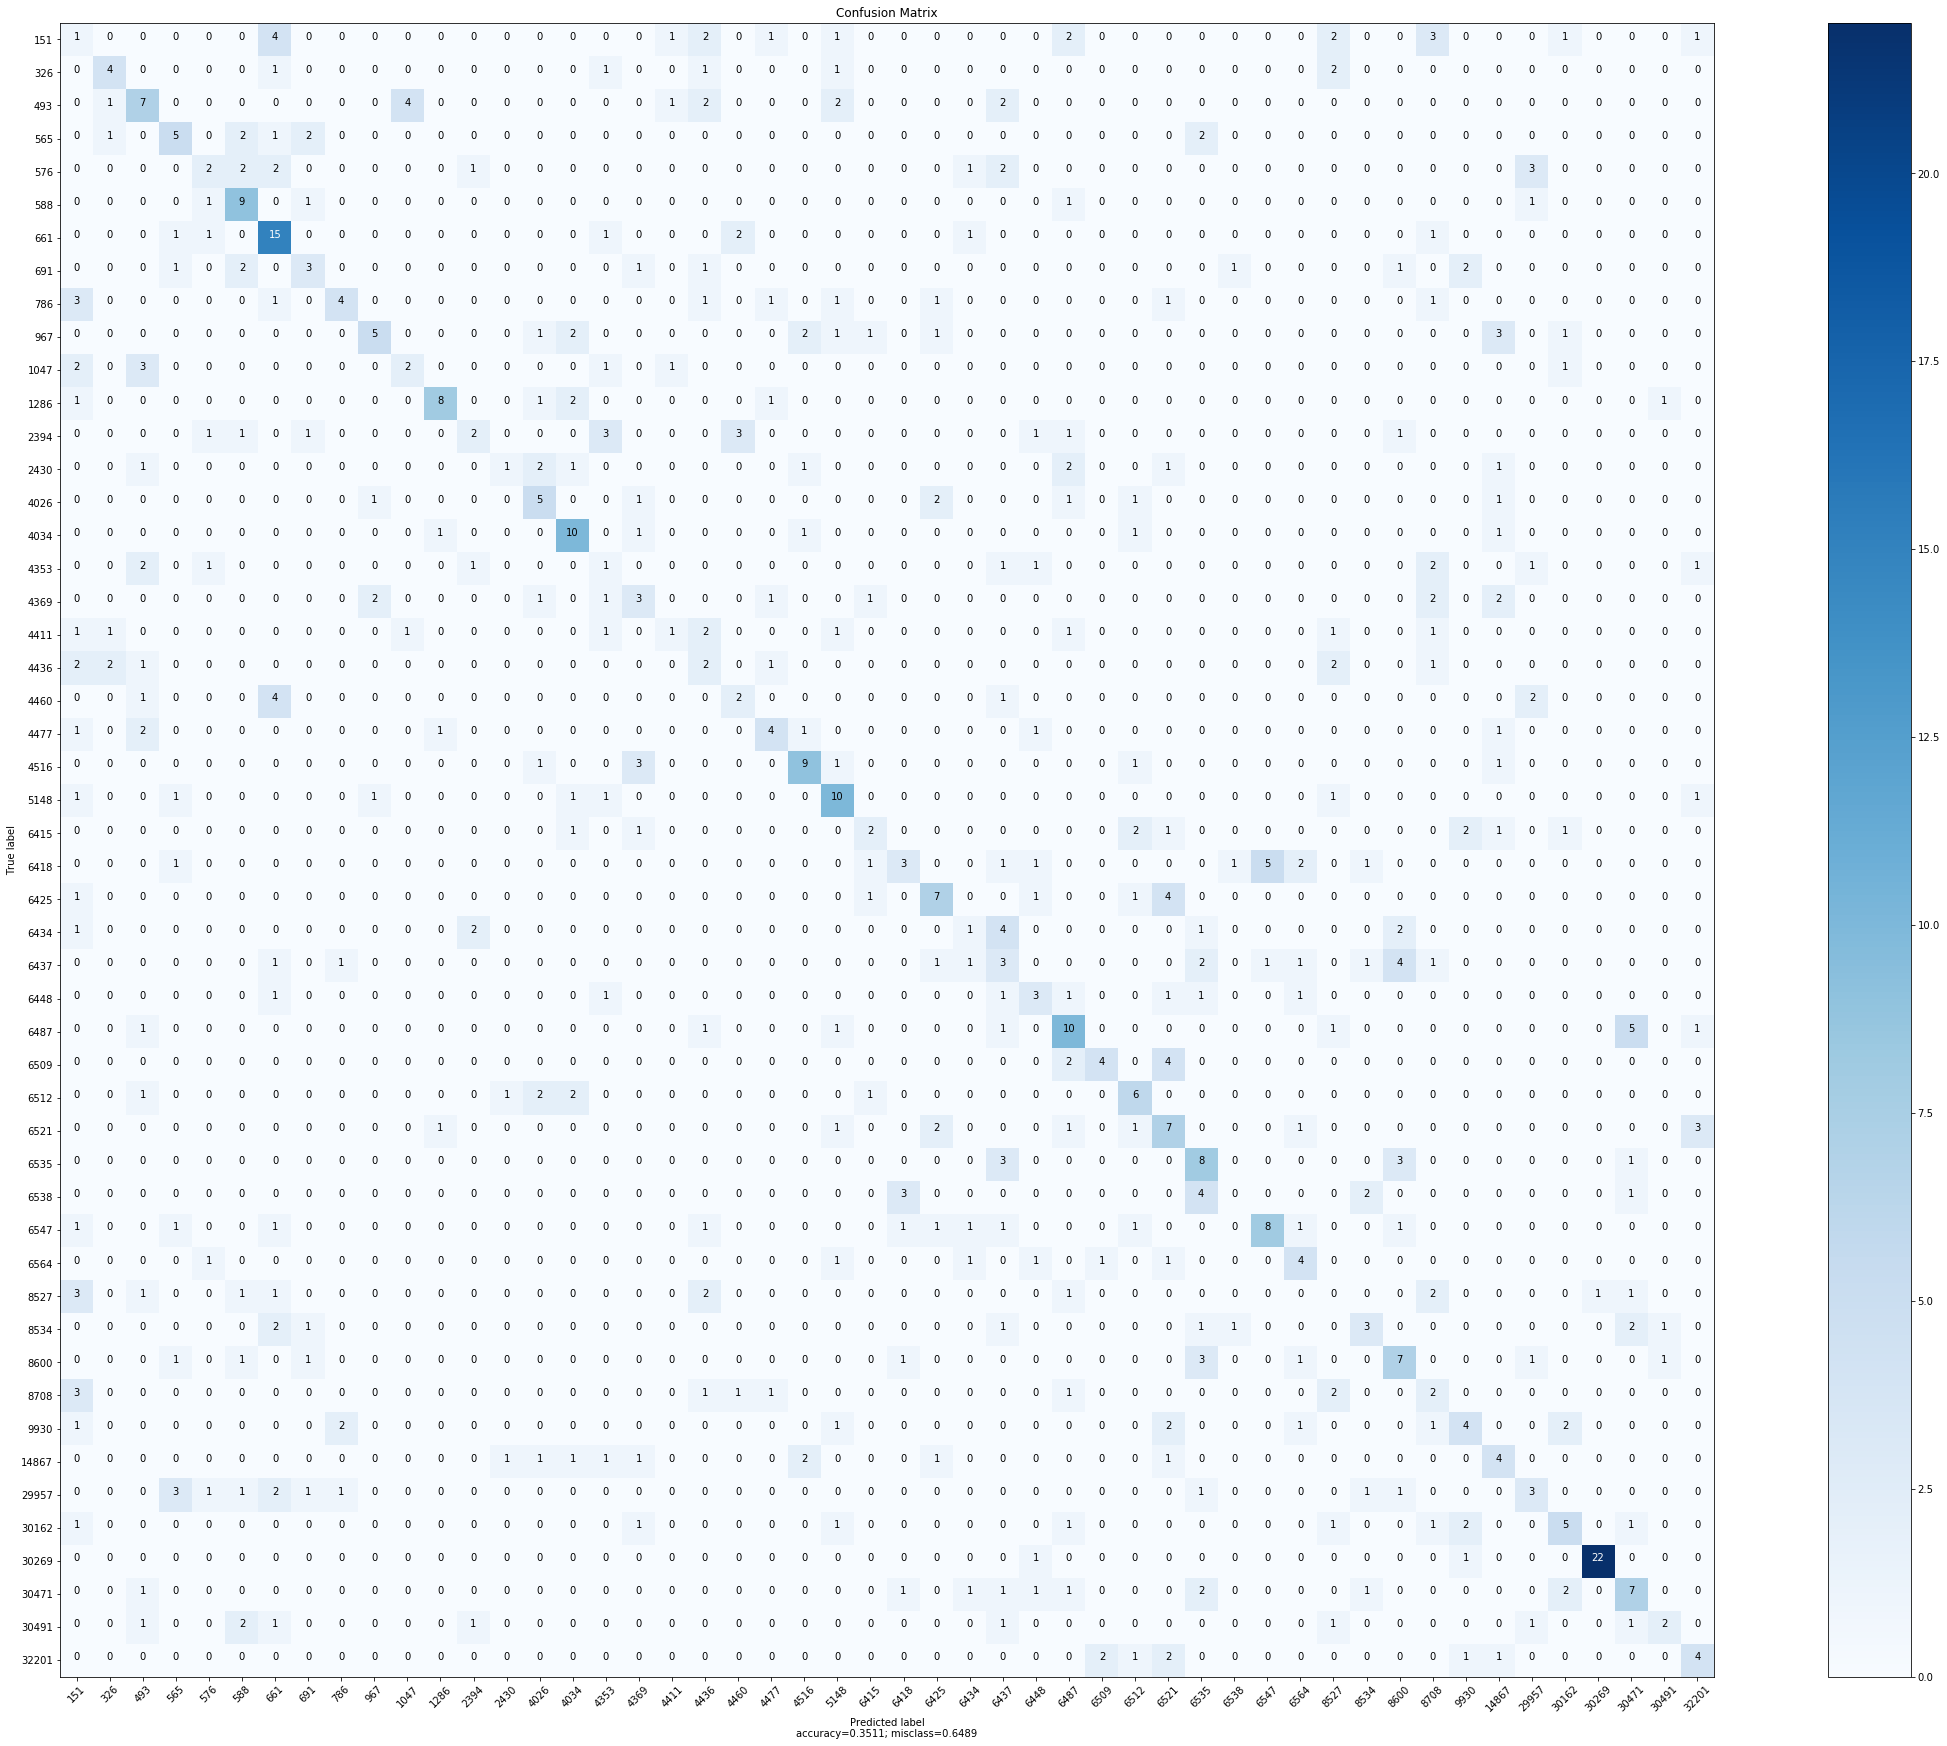

In [21]:
cm = confusion_matrix(y_true, y_predict)
plot_confusion_matrix(cm = cm, normalize = False, target_names = classes, title = "Confusion Matrix")